# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.stats.api as sms # for comparison of means t-test. 

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [4]:
sum(data[data.race=='w'].call)

235.0

In [5]:
data.race.value_counts()

b    2435
w    2435
Name: race, dtype: int64

In [6]:
data.shape

(4870, 65)

<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();
_ = sns.barplot(x='race', y='call', data=data)

C:\Users\ryatchak\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


1. A two-sample t-test is appropriate here since we don't know the true standard deviation of the samples. Yes, the central limit theorem applies. The sample size of 4870 is sufficiently large, and the data is independent. 
2. Let $\mu_w$ be the mean of callbacks for white-sounding names, and $\mu_b$ be the mean of callbacks for black-sounding names. The null hypothesis is that $\mu_w=\mu_b$. The alternative hypothesis is that $\mu_b\neq\mu_w$. 

In [8]:
w = data[data.race=='w']
b = data[data.race=='b']

In [9]:
# Your solution to Q3 here

#### Bootstrap method

In [37]:
def draw_bs_reps(data, func, size=1, sample_size=len(data)):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

def draw_bs(data, size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i]= np.random.choice(data, size=len(data))

    return bs_replicates 

mean_call = np.mean(data.call)
observed_diff = np.mean(w.call) - np.mean(b.call)

w_shifted = w.call - np.mean(w.call) + mean_call
b_shifted = b.call - np.mean(b.call) + mean_call 

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_w = draw_bs_reps(w_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(b_shifted, np.mean, size = 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_w - bs_replicates_b

std_err = np.std(bs_replicates)
# Compute and print p-value: p
t_value = stats.t.ppf(1-0.025, 4869)
p = np.sum(bs_replicates >= (observed_diff)) / 10000 # something is strange here. 
print('Observed rate of callbacks=',observed_diff)
print('p-value =', p)
print('Confidence interval: {}'.format(np.percentile(bs_replicates,[2.5, 97.5])))
print('Margin of error: {}'.format(stats.t.ppf(1-0.025, 4869)*std_err))

Observed rate of callbacks= 0.03203285485506058
p-value = 0.0
Confidence interval: [-0.01519509  0.01519505]
Margin of error: 0.015244088406093145


In [27]:
observed_diff

0.03203285485506058

The p-value is truly zero, and the confidence interval is also unexpected. This is a very strange result, especially compared to the outcome of the frequentist method....

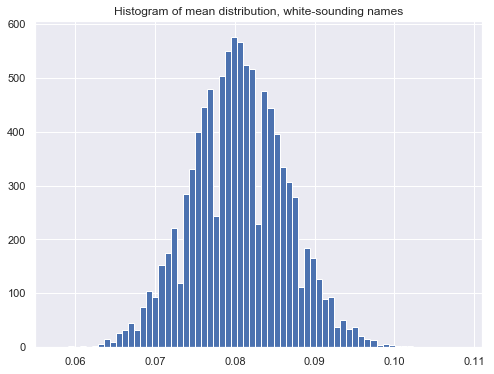

In [18]:
_ = plt.subplots(figsize=(8,6))
_ = plt.hist(bs_replicates_w, bins='auto')
_ = plt.title('Histogram of mean distribution, white-sounding names')
_ = plt.show()

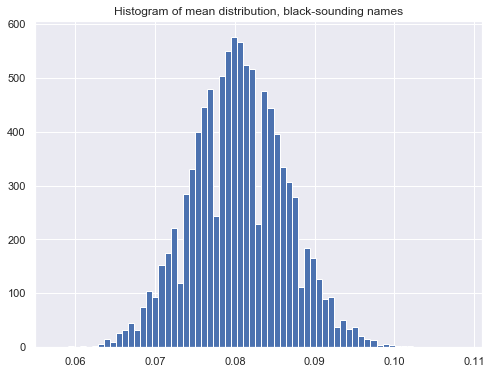

In [19]:
_ = plt.subplots(figsize=(8,6))
_ = plt.hist(bs_replicates_w, bins='auto')
_ = plt.title('Histogram of mean distribution, black-sounding names')
_ = plt.show()

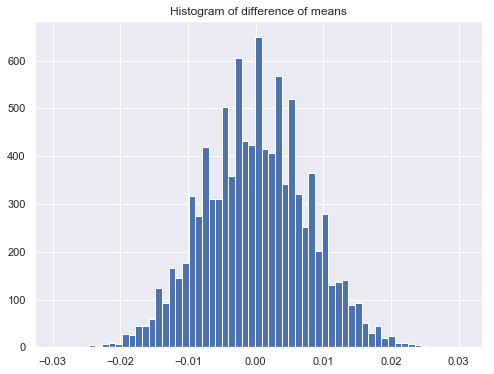

In [17]:
_ = plt.subplots(figsize=(8,6))
_ = plt.hist(bs_replicates, bins='auto')
_ = plt.title('Histogram of difference of means')
_ = plt.show()

It seems that using bootstrapping to test the true mean of this sample is not the right approach here. Let's try the number of callbacks instead... 

In [54]:
# try sum instead... 
sum_call = np.sum(data.call)
sum_observed_diff = np.sum(w.call) - np.sum(b.call)

# Compute 10,000 bootstrap replicates
bs_replicates_w = draw_bs_reps(w.call, np.sum, 10000, 1000)
bs_replicates_b = draw_bs_reps(b.call, np.sum, 10000, 1000)

# Get replicates of difference
bs_replicates = bs_replicates_w - bs_replicates_b

std_err = np.std(bs_replicates)
# Compute and print p-value: p
t_value = stats.t.ppf(1-0.025, 4869)
p = np.sum(bs_replicates >= (observed_diff)) / 10000 # something is strange here. 
print('Observed difference in number of callbacks=',sum_observed_diff)
print('p-value =', p)
print('Confidence interval: {}'.format(np.percentile(bs_replicates,[2.5, 97.5])))
print('Margin of error: {}'.format(stats.t.ppf(1-0.025, 4869)*std_err))

Observed difference in number of callbacks= 78.0
p-value = 0.9999
Confidence interval: [ 41. 116.]
Margin of error: 37.58978977791098


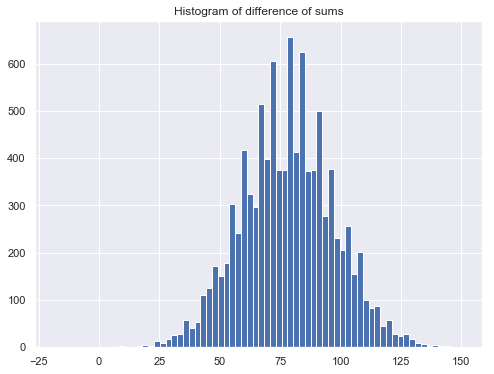

In [56]:
_ = plt.subplots(figsize=(8,6))
_ = plt.hist(bs_replicates, bins='auto')
_ = plt.title('Histogram of difference of sums')
_ = plt.show()

Here we resample the original sample and test the difference in the number of callbacks among the resampled white and black candidates. 

$H_0$: the number of callbacks is the same between candidates with white- and black-sounding names

Alternative hypothesis: The number of callbacks among these two groups is not equal. 

We reject the null hypothesis: the number of callbacks is not the same for both groups. 

In [58]:
callback_b = np.mean(bs_replicates_b)
callback_w = np.mean(bs_replicates_w)
print('Empirical number of callbacks, black-sounding names:', callback_b)
print('Empirical rate of callbacks, black-sounding names:', callback_b/2000)
print('Empirical number of callbacks, white-sounding names:', callback_w)
print('Empirical rate of callbacks, white-sounding names:', callback_w/2000)

Empirical number of callbacks, black-sounding names: 156.9402
Empirical rate of callbacks, black-sounding names: 0.0784701
Empirical number of callbacks, white-sounding names: 235.0022
Empirical rate of callbacks, white-sounding names: 0.1175011


#### Frequentist method

In [12]:
compare_means_obj = sms.CompareMeans.from_data(w.call, b.call)
t_test= compare_means_obj.ttest_ind()
print('p_value=', t_test[0])
print('Confidence interval: ', compare_means_obj.tconfint_diff())
std_err_freq = np.sqrt(((np.std(w.call)**2)/w.shape[0])+ ((np.std(b.call)**2)/b.shape[0]))
print('Margin of error: {}'.format(stats.t.ppf(1-0.025, 4869)*std_err_freq))

p_value= 4.114705246593625
Confidence interval:  (0.016770799977396562, 0.04729490844149461)
Margin of error: 0.015258797171631415


<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

## 4. Write a story describing the statistical significance in the context or the original problem.

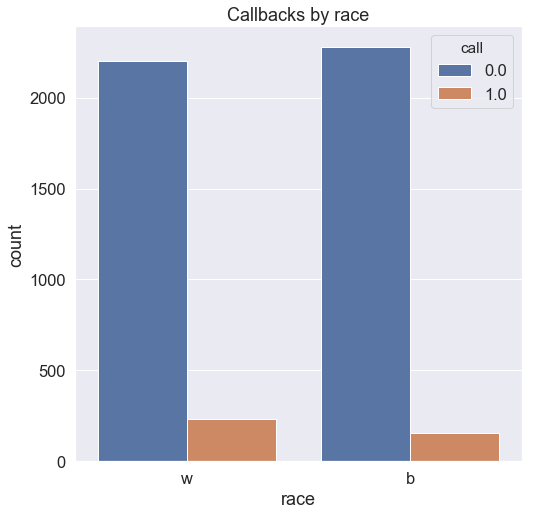

In [59]:
_= sns.set(font_scale=1.5)
_= plt.subplots(figsize=(8,8))
_ = sns.countplot(x='race', hue='call', data=data)
_ = plt.title('Callbacks by race')

In [60]:
print('{}% of candidates with white-sounding names received callbacks'.format((sum(w.call)/len(w))*100))
print('{}% of candidates with black-sounding names received callbacks'.format((sum(b.call)/len(b))*100))

9.650924024640657% of candidates with white-sounding names received callbacks
6.447638603696099% of candidates with black-sounding names received callbacks


Candidates with black-sounding names appear to receive fewer callbacks. Our frequentist hypothesis testing concluded that this difference is statistically significant! 

However, this hypothesis did not take educational background, years of experience, and other factors into account. 

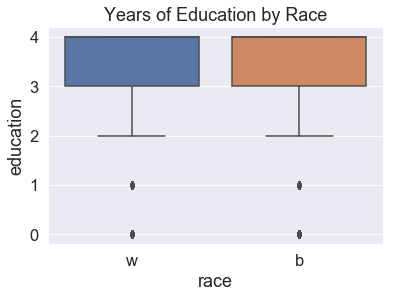

In [61]:
_ = sns.boxplot(x = 'race', y='education', 
               data=data)
_ = plt.title('Years of Education by Race')

The educational background of populations of both races appears to be similar. 

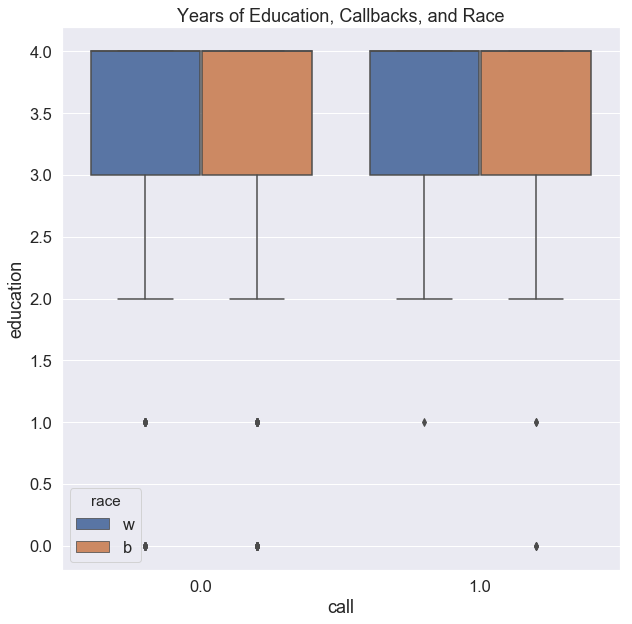

In [62]:
_ = plt.subplots(figsize=(10,10))
_ = sns.boxplot(x='call', y='education', hue='race', data=data)
_= plt.title('Years of Education, Callbacks, and Race')

Based on years of education, there appears to be no bias in callback rate for people of different racial backgrounds. 

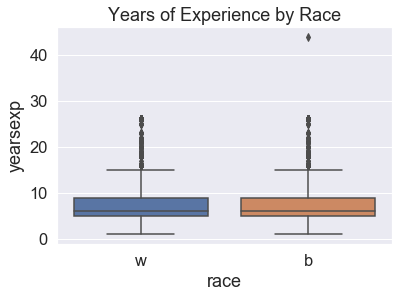

In [63]:
_ = sns.boxplot(x = 'race', y='yearsexp', 
               data=data)
_ = plt.title('Years of Experience by Race')

The years of experience also appear to be similar. 

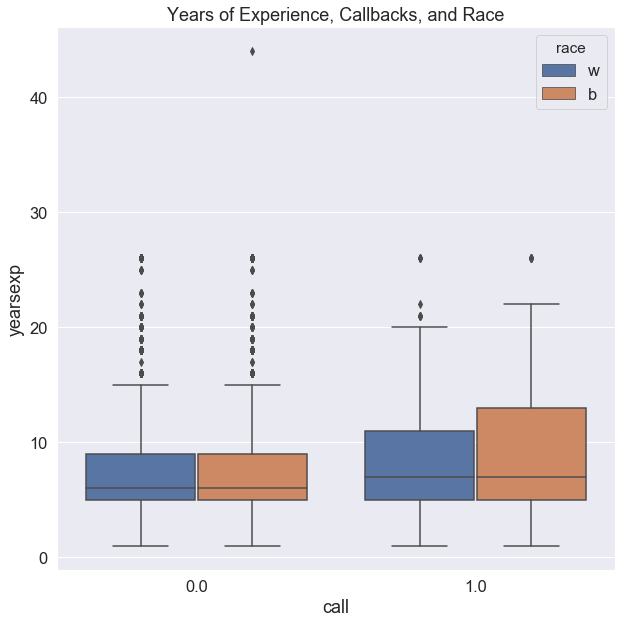

In [64]:
_ = plt.subplots(figsize=(10,10))
_ = sns.boxplot(x='call', y='yearsexp', hue='race', data=data)
_= plt.title('Years of Experience, Callbacks, and Race')

Here, we see some indicator of possible racial background discrimination

In [65]:
table = pd.pivot_table(data[['race', 'call', 'empholes']], values= ['call'], index=['race','empholes'], aggfunc=np.sum)
table['percentage of all called back'] = table.call/np.sum(table.call)*100
table = table.reset_index()

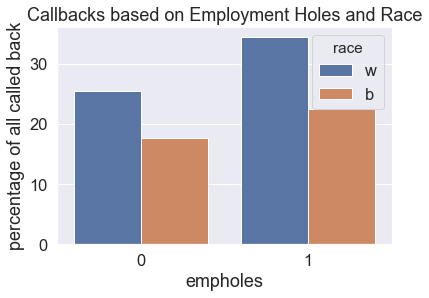

In [66]:
_ = sns.barplot(x='empholes', y='percentage of all called back', hue='race', hue_order=['w', 'b'], data=table)
_ = plt.title('Callbacks based on Employment Holes and Race')

Candidates with gaps in their employment record (emphole = 1) are common. The number of employment holes can affect employment decisions. There may be a racial bias here: are candidates with black-sounding names and employment holes less likely to be hired than candidates with black-sounding names and employment holes? 

## 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

What we tested was whether or not there is a statistically significant difference in the number of callbacks for white candidates and black candidates. We showed that there is a correlation between race and callback: namely, candidates with black-sounding names are less likely to receive a callback than a candidate with a white-sounding name. 

We have not shown that this is the most important factor in callback success. This would require carrying out statistical significance test for other parameters (such as education, number of jobs, years of experience, employment holes, etc). 

The hypothesis we would really want to test to see if we can argue that race is the most important factor is: candidates with white-sounding names and black-sounding names that have similar qualifications are equally likely to receive a callback. 

Rejecting this null hypothesis would prove more compelling evidence that race is a very important factor in callback success. 

Another possible avenue would be to try developing a logistic regression model to predict callbacks for candidates. Seeing whether race is one of the most defining features in this model would be very interesting. 